# Color Quantization

## Median Cut

In [24]:
from PIL import Image

def quantize_pil(input_path, n_colors=16, dither=False):
    output_path = f'../notebooks/quantized-{n_colors}.jpeg'
    print(output_path)
    img = Image.open(input_path).convert('RGB')
    quant = img.quantize(
        colors=n_colors,
        method=Image.MEDIANCUT,
        dither=Image.FLOYDSTEINBERG if dither else Image.NONE
    )
    quant.show()
    quant.convert('RGB').save(output_path)
    return quant

input_path = "../test-images-mnz/castle_and_guards.jpeg"


img = quantize_pil(input_path, n_colors=14, dither=False)


../notebooks/quantized-14.jpeg


## Facet Reduction

In [22]:
import cv2


d = 5
sigmacolor = 50
sigmaspace = 50
# load

img = cv2.imread('quantized-16.jpeg')

# apply bilateral filter
#   d=9       : diameter of each pixel’s neighbourhood
#   sigmaColor=75, sigmaSpace=75 : how strongly to smooth colours and space
smoothed = cv2.bilateralFilter(img, d=d, sigmaColor=sigmacolor, sigmaSpace=sigmaspace)

# save
cv2.imwrite(f'smoothed_16_d-{d}_color-{sigmacolor}_space-{sigmaspace}.png', smoothed)


True

# Contour detection

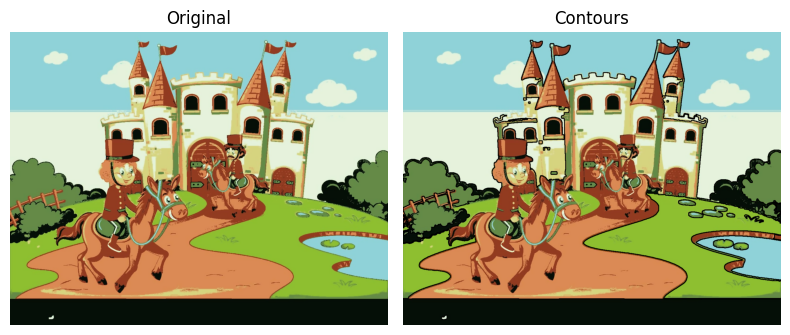

Saved to contours.png


In [27]:
import cv2
import matplotlib.pyplot as plt

# Read the image that the user referenced
img_path = "smoothed.png"
img = cv2.imread(img_path)

# Convert to grayscale – contours are typically detected on single‑channel images
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# A little blurring helps clean up small colour noise before edge detection
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect edges – these mark most colour boundaries in a cartoon‑style frame
edges = cv2.Canny(blur, 50, 150)

# Dilate the edges so that the contour extraction gets continuous curves
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
edges_dil = cv2.dilate(edges, kernel, iterations=1)

# Extract contours
contours, _ = cv2.findContours(edges_dil, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on top of the original
contour_img = img.copy()
cv2.drawContours(contour_img, contours, -1, (0, 0, 0), 2)



# Show the result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Contours")
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the result so the user can download it if they wish
output_path = ("contours.png")
cv2.imwrite(output_path, contour_img)
print(f"Saved to {output_path}")


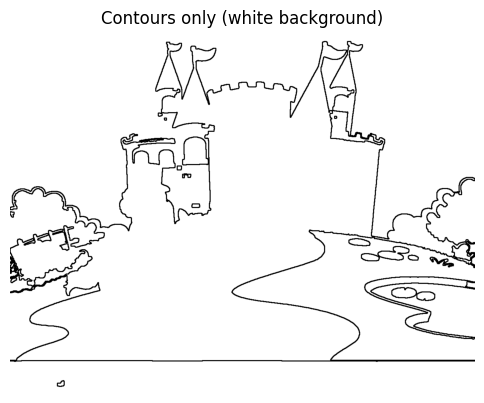

Saved to contours_only.png


In [29]:
h, w = img.shape[:2]
contour_canvas = np.ones((h, w, 3), dtype=np.uint8) * 255  # white background

# draw black lines; increase thickness if you want a bolder stroke
cv2.drawContours(contour_canvas, contours, -1, (0, 0, 0), thickness=2)
# ----------------------------------------------------------------------------

# show the result
plt.figure(figsize=(6, 6))
plt.title("Contours only (white background)")
plt.imshow(cv2.cvtColor(contour_canvas, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# save so the user can download
out_path = "contours_only.png"
cv2.imwrite(out_path, contour_canvas)
print(f"Saved to {out_path}")

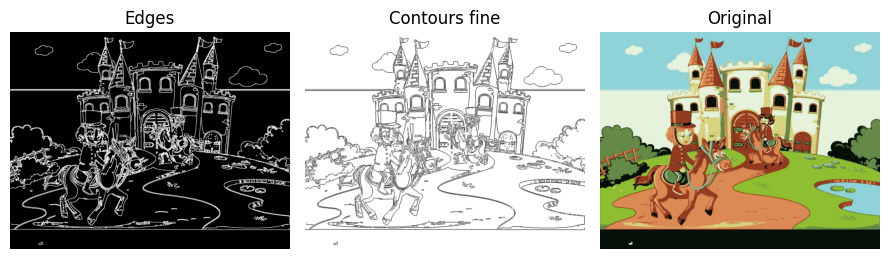

Saved fine‑grained contours to contours_fine_3x3.png


In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the same demo image (replace with your own path)
img_path = "smoothed.png"
img = cv2.imread(img_path)
if img is None:
    raise IOError(f"Could not read {img_path}")

# --- 1. More gentle pre‑blur (preserve detail) ------------------------------
gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur  = cv2.GaussianBlur(gray, (3, 3), 0)  # smaller kernel than before #Todo: Was (3, 3) before changes

# --- 2. Lower Canny thresholds for finer edges ------------------------------
edges = cv2.Canny(blur, 35, 90)            # was 50,150

# --- 3. OPTIONAL: close tiny gaps so contours are continuous ----------------
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
edges  = cv2.dilate(edges, kernel, iterations=1)

# --- 4. Find ALL contours, not just outer shell -----------------------------
contours, hierarchy = cv2.findContours(
    edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
)

# --- 5. Draw on clean canvas -------------------------------------------------
h, w = img.shape[:2]
canvas = np.ones((h, w, 3), dtype=np.uint8) * 255
cv2.drawContours(canvas, contours, -1, (0, 0, 0), thickness=1)

# Show comparison
plt.figure(figsize=(9, 4))
plt.subplot(1, 3, 1)
plt.title("Edges")
plt.imshow(edges, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Contours fine")
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.tight_layout()
plt.show()

# Save output
out_path = "contours_fine_3x3.png"
cv2.imwrite(out_path, canvas)
print(f"Saved fine‑grained contours to {out_path}")


In [37]:
import cv2
import numpy as np
import os

# ------------------------------------------------------------------
# 1. CONFIG ‑‑ tweak these lists to try other values
# ------------------------------------------------------------------
blur_kernels   = [3, 5, 7]                     # Gaussian kernel sizes (must be odd)
canny_settings = [(25, 80), (40, 120), (60, 180)]  # (low, high) threshold pairs
dilate_iters   = [0, 1]                        # 0 = no dilation, 1 = close fine gaps
thicknesses    = [1]                           # stroke width when drawing

# Source image
img_path = "/Users/luca/Documents/HSLU/cvai/mnz/notebooks/smoothed_20_75_75.png"    # update to your own image if needed

# Destination directory
out_dir = "notebooks/finetuning"
os.makedirs(out_dir, exist_ok=True)
print("Saving outputs to:", out_dir)

# ------------------------------------------------------------------
# 2. Load image once
# ------------------------------------------------------------------
img  = cv2.imread(img_path)
if img is None:
    raise IOError(f"Could not read {img_path}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = img.shape[:2]

saved_files = []

# ------------------------------------------------------------------
# 3. Iterate over parameter grid
# ------------------------------------------------------------------
for k in blur_kernels:
    # Pre‑compute blurred image for this kernel
    blur = cv2.GaussianBlur(gray, (k, k), 0)

    for low, high in canny_settings:
        # Edge map
        edges = cv2.Canny(blur, low, high)

        for d in dilate_iters:
            if d > 0:
                edges_dil = cv2.dilate(edges, np.ones((3, 3), np.uint8), iterations=d)
            else:
                edges_dil = edges

            # Contours (keep nested)
            contours, _ = cv2.findContours(edges_dil, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # OPTIONAL: filter out very small specks here
            # contours = [c for c in contours if cv2.contourArea(c) > 30]

            for t in thicknesses:
                # Blank white canvas
                canvas = np.ones((h, w, 3), np.uint8) * 255
                cv2.drawContours(canvas, contours, -1, (0, 0, 0), thickness=t)

                # Build filename that encodes parameters
                fname = (
                    f"contour_k{k}"
                    f"_c{low}-{high}"
                    f"_d{d}"
                    f"_th{t}.png"
                )
                fpath = os.path.join(out_dir, fname)
                cv2.imwrite(fpath, canvas)
                saved_files.append(fname)

# ------------------------------------------------------------------
# 4. Report
# ------------------------------------------------------------------
print("Generated", len(saved_files), "images:")
for f in saved_files:
    print("  ", f)




Saving outputs to: notebooks/finetuning
Generated 18 images:
   contour_k3_c25-80_d0_th1.png
   contour_k3_c25-80_d1_th1.png
   contour_k3_c40-120_d0_th1.png
   contour_k3_c40-120_d1_th1.png
   contour_k3_c60-180_d0_th1.png
   contour_k3_c60-180_d1_th1.png
   contour_k5_c25-80_d0_th1.png
   contour_k5_c25-80_d1_th1.png
   contour_k5_c40-120_d0_th1.png
   contour_k5_c40-120_d1_th1.png
   contour_k5_c60-180_d0_th1.png
   contour_k5_c60-180_d1_th1.png
   contour_k7_c25-80_d0_th1.png
   contour_k7_c25-80_d1_th1.png
   contour_k7_c40-120_d0_th1.png
   contour_k7_c40-120_d1_th1.png
   contour_k7_c60-180_d0_th1.png
   contour_k7_c60-180_d1_th1.png
